# Computing WSLFP stepwise
The downside to computing WSLFP stepwise (causally) is that the summed currents are normalized over time before being multiplied by the signal amplitude.
This leaves us with three options:
- use unnormalized WSLFP if we don't need realistic scale (e.g., -0.1 to 0.1 μV)
- use a predetermined mean and standard deviation to normalize
- causally estimate the mean and standard deviation as we go

In [28]:
import brian2.only as b2
import matplotlib.pyplot as plt
import numpy as np

b2.prefs.codegen.target = "numpy"
b2.seed(18290515)
rng = np.random.default_rng(18290515)

In [29]:
N_excit = 800
N_inhib = None  # None = N_excit / 4
N_extern = 1000
connection_probability = 0.1
# w0 = 0.1 * b2.mV
w0 = 0.07 * b2.nA
g = 4
synaptic_delay = 1.5 * b2.ms
# poisson_input_rate = 13 * b2.Hz
poisson_input_rate = 9 * b2.Hz
# w_external = None
w_external = 0.1 * b2.mV
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
membrane_time_scale = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms
random_vm_init = True

if N_inhib is None:
    N_inhib = int(N_excit / 4)
N_tot = N_excit + N_inhib
if N_extern is None:
    N_extern = int(N_excit * connection_probability)
if w_external is None:
    w_external = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
    dv/dt = (-(v-v_rest) + Rm*(I_ampa + I_gaba)) / membrane_time_scale : volt (unless refractory)
    I_ampa : amp
    I_gaba : amp
"""

neurons = b2.NeuronGroup(
    N_tot,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
if random_vm_init:
    neurons.v = (
        np.random.uniform(
            v_rest / b2.mV, high=firing_threshold / b2.mV, size=(N_excit + N_inhib)
        )
        * b2.mV
    )
else:
    neurons.v = v_rest

excitatory_population = neurons[:N_excit]
inhibitory_population = neurons[N_excit:]

syn_eqs = """
    dI_syn_syn/dt = (s - I_syn_syn)/tau_dsyn : amp (clock-driven)
    I_TYPE_post = I_syn_syn : amp (summed)
    ds/dt = -s/tau_rsyn : amp (clock-driven)
"""

exc_synapses = b2.Synapses(
    excitatory_population,
    target=neurons,
    model=syn_eqs.replace("TYPE", "ampa"),
    on_pre="s += J_excit",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms},
)
exc_synapses.connect(p=connection_probability)

inhib_synapses = b2.Synapses(
    inhibitory_population,
    target=neurons,
    model=syn_eqs.replace("TYPE", "gaba"),
    on_pre="s += J_inhib",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.25 * b2.ms, "tau_dsyn": 5 * b2.ms},
)
inhib_synapses.connect(p=connection_probability)

external_poisson_input = b2.PoissonInput(
    target=neurons,
    target_var="v",
    N=N_extern,
    rate=poisson_input_rate,
    weight=w_external,
)

spike_monitor = b2.SpikeMonitor(neurons, record=True)
current_monitor = b2.StateMonitor(neurons, ["I_ampa", "I_gaba"], record=range(N_excit))

net = b2.Network(
    neurons,
    exc_synapses,
    inhib_synapses,
    external_poisson_input,
    spike_monitor,
    current_monitor,
)

net.run(0.5 * b2.second)

INFO       No numerical integration method specified for group 'synapses_2', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


</details>

Now let's plot the resulting spike raster:

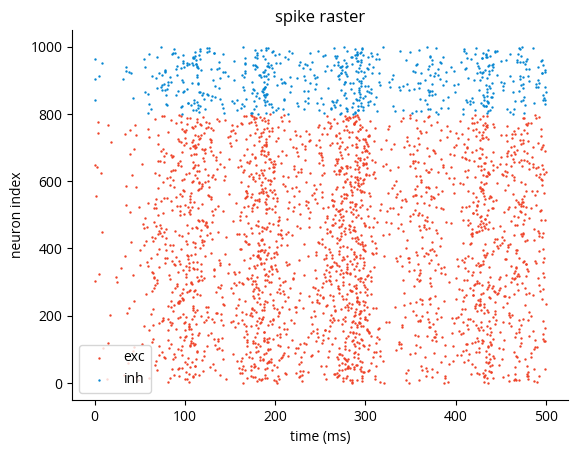

In [30]:
fig, ax1 = plt.subplots()
c_exc = "xkcd:tomato"
c_inh = "xkcd:cerulean"
t_spk_exc = spike_monitor.t[spike_monitor.i < N_excit] / b2.ms
i_spk_exc = spike_monitor.i[spike_monitor.i < N_excit]
t_spk_inh = spike_monitor.t[spike_monitor.i >= N_excit] / b2.ms
i_spk_inh = spike_monitor.i[spike_monitor.i >= N_excit]
ax1.scatter(t_spk_exc, i_spk_exc, s=0.5, c=c_exc, label="exc")
ax1.scatter(t_spk_inh, i_spk_inh, s=0.5, c=c_inh, label="inh")
ax1.legend()
ax1.set(xlabel="time (ms)", ylabel="neuron index", title="spike raster");

In [31]:
exc_coords = rng.uniform(-250, 250, (N_excit, 3))
rec_radii = np.array([0, 250, 500])
elec_coords = np.meshgrid(rec_radii, [0], np.linspace(-400, 600, 10))
elec_coords = np.column_stack([a.flatten() for a in elec_coords])

In [32]:
import wslfp

lfp_calc = wslfp.from_xyz_coords(elec_coords, exc_coords, amp_func=wslfp.mazzoni15_nrn)

Either pass in the mean and standard deviation to standardize as you go, or, if you don't care about absolute scale (the exact microvolt range, for example), just don't normalize:

In [33]:
t_ms = current_monitor.t / b2.ms
t_eval_ms = np.arange(500)
wsums = np.zeros((len(t_eval_ms), 30))
lfp_causal = np.zeros((len(t_eval_ms), 30))
lfp_unnorm = np.zeros((len(t_eval_ms), 30))

wsum_mean = 0
wsum_std = 1
for i, t in enumerate(t_eval_ms):
    i_I_ampa = np.where(t_ms == t - lfp_calc.tau_ampa_ms)
    i_I_gaba = np.where(t_ms == t - lfp_calc.tau_gaba_ms)
    lfp_causal[i], wsums[i] = lfp_calc.calculate(
        [t],
        t_ms[i_I_ampa],
        current_monitor.I_ampa_.T[i_I_ampa],
        t_ms[i_I_gaba],
        current_monitor.I_gaba_.T[i_I_gaba],
        wsum_mean_std_for_norm=(wsum_mean, wsum_std),
    )
    wsum_mean = np.mean(wsums[: i + 1], axis=0)
    wsum_std = np.std(wsums[: i + 1], axis=0)
    wsum_std[wsum_std == 0] = 1

    lfp_unnorm[i] = lfp_calc.calculate(
        [t],
        t_ms[i_I_ampa],
        current_monitor.I_ampa.T[i_I_ampa],
        t_ms[i_I_gaba],
        current_monitor.I_gaba.T[i_I_gaba],
        normalize=False,
    )

In [34]:
wsum_mean, wsum_std

(array([ 3.13504120e-10,  5.70402656e-10,  8.75330715e-10,  7.73968346e-10,
         3.26955271e-10, -1.20556132e-10, -5.83611936e-10, -9.20051153e-10,
        -7.15193919e-10, -4.15280938e-10,  2.62512962e-10,  4.15412877e-10,
         5.78956870e-10,  5.20734016e-10,  2.55372212e-10, -5.51081739e-11,
        -3.95609702e-10, -6.26364849e-10, -5.16270621e-10, -3.34405016e-10,
         1.18582486e-10,  1.56739891e-10,  1.71890170e-10,  1.47882757e-10,
         8.01772630e-11, -2.12624259e-11, -1.14767039e-10, -1.68688661e-10,
        -1.70785851e-10, -1.40634406e-10]),
 array([2.41452790e-10, 4.39026413e-10, 6.73326064e-10, 5.95989127e-10,
        2.53592601e-10, 9.77612136e-11, 4.51972260e-10, 7.08541662e-10,
        5.49823799e-10, 3.18905323e-10, 2.02154897e-10, 3.20242696e-10,
        4.46750069e-10, 4.01947154e-10, 1.97214175e-10, 4.86796166e-11,
        3.06985191e-10, 4.83005595e-10, 3.97216412e-10, 2.56879807e-10,
        9.14661002e-11, 1.20876169e-10, 1.32590568e-10, 1.140511

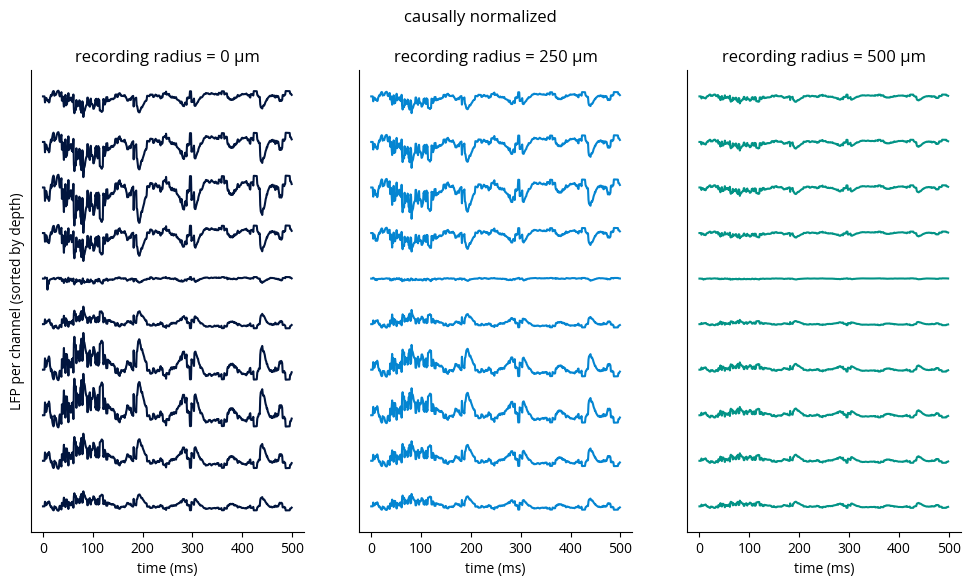

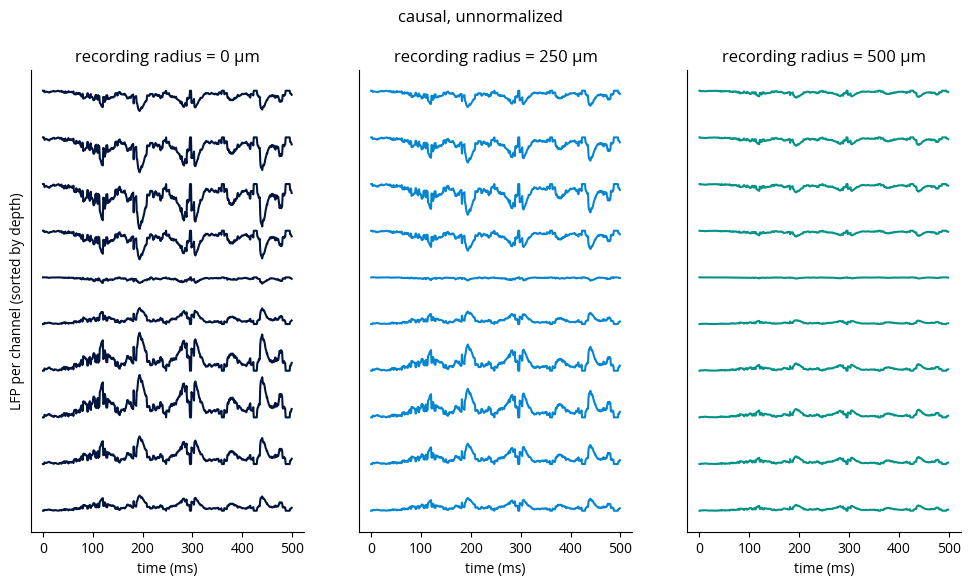

In [35]:
def plot_lfp(lfp, title=None):
    n_shanks = 3
    n_contacts_per_shank = 10
    fig, axs = plt.subplots(1, n_shanks, sharey=True, figsize=(12, 6))
    for i, color, r_rec, ax in zip(
        range(n_shanks), ["xkcd:navy", "xkcd:cerulean", "xkcd:teal"], rec_radii, axs
    ):
        lfp_for_shank = lfp[
            :, i * n_contacts_per_shank : (i + 1) * n_contacts_per_shank
        ]
        ax.plot(
            t_eval_ms,
            lfp_for_shank + np.arange(n_contacts_per_shank) * 1.1 * np.abs(lfp.max()),
            c=color,
        )
        ax.set(xlabel="time (ms)", yticks=[], title=f"recording radius = {r_rec} µm")

    axs[0].set(ylabel="LFP per channel (sorted by depth)")
    if title:
        fig.suptitle(title)


plot_lfp(lfp_causal, "causally normalized")
plot_lfp(lfp_unnorm, "causal, unnormalized")

As we could have guessed, the causal normalization distorts the values at the beginning.
I recommend using unnormalized LFP in real time.
If we need a realistic, absolute scale, we can normalize post-hoc.